# Imports and Functions

In [39]:
import pandas as pd
import numpy as np
from scipy import stats
from distfit import distfit
import altair as alt
import matplotlib.pyplot as plt

def dt_to_min(dt):
    if type(dt) == str:
        hour, minute = map(int, dt.split(":"))
        return hour * 60 + minute
    
    return dt.hour * 60 + dt.minute

def min_to_dt(min):
    return f"{min // 60:02d}:{min % 60:02d}"

In [40]:
login_datetime_df = pd.read_csv("./data/final_data/ip_logs.csv")
login_datetime_df["Date"] = login_datetime_df["Date"].astype("datetime64[ns]")
login_datetime_df["TimeInMinutes"] = login_datetime_df["Date"].map(dt_to_min)

# Read my weekly schedule from json file
import json
with open("./data/final_data/schedule.json", "r") as f:
    weekly_schedule = json.load(f)

In [41]:
post_votes_df = pd.read_csv("./data/final_data/post_votes.csv").rename(columns={"Scores": "Score"})
comment_votes_df = pd.read_csv("./data/final_data/comment_votes.csv")

In [42]:
posts_df = pd.read_csv("./data/final_data/post_headers.csv").rename(columns={"Scores": "Score"})
comments_df = pd.read_csv("./data/final_data/comment_headers.csv")

In [43]:
subreddits_df = pd.read_csv("./data/final_data/subscribed_subreddits.csv")

# Data Analysis

## Active Times

Using daily login time data I will try to make an analysis on my active times.

### Hypothesis

My hypothesis is that I am more active during my classes and less active during my free times.

**Null Hypothesis**: I am equally active during my classes and free times.  
**Alternative Hypothesis**: I am more active during my classes and less active during my free times.

### Method
I will group my logins as _classHours_ and _freeHours_ and build two group of distributions for the number of logins in each interval. Then I will use a _t-test_ to see if there is a significant difference between the two groups. (Selecting a significance level of 0.05.)

In [44]:
# Perform t-test for each day
test_results = {}
for day in weekly_schedule.keys():
    # Get the class times for labeling intervals
    classTimes = []
    schedule = weekly_schedule[day]["classes"]
    for c in schedule:
        start_time = dt_to_min(c["startTime"]) - 10
        end_time = dt_to_min(c["endTime"])
        classCount = (end_time - start_time) // 60
        classTimes += [start_time + i*30 for i in range(classCount*2)]

    # Create the intervals
    login_intervals_df = pd.DataFrame(columns=["IntervalStart", "IntervalType", "LoginCount"])
    login_intervals_df.loc[:, "IntervalStart"] = [i for i in range(0, 24*60, 30)]
    login_intervals_df.loc[:, "LoginCount"] = 0
    login_intervals_df["LoginCount"] = login_intervals_df["LoginCount"].astype(dtype="int64")
    login_intervals_df.loc[:, "IntervalType"] = ["class" if i in classTimes else "free" for i in login_intervals_df["IntervalStart"]]  # Label the intervals
    # Count the logins for each interval
    for loginTime in login_datetime_df[login_datetime_df["DayName"] == day]["TimeInMinutes"]:
        intervalIdx = loginTime // 30
        login_intervals_df.loc[intervalIdx, "LoginCount"] += 1

    mean = login_intervals_df["LoginCount"].mean()
    peak = login_intervals_df["LoginCount"].max()
    peak_interval = login_intervals_df[login_intervals_df["LoginCount"] == peak]["IntervalStart"].iloc[0]
    free_times = login_intervals_df[login_intervals_df["IntervalType"] == "free"]["LoginCount"]  # Get the login counts for free times
    class_times = login_intervals_df[login_intervals_df["IntervalType"] == "class"]["LoginCount"]  # Get the login counts for class times
    
    # Perform t-test
    result = stats.ttest_ind(class_times, free_times, equal_var=False)  # since we have not equal variances
    test_results[day] = [result, [mean, peak, peak_interval]]

alpha = 0.05  # Set the significance level
for day, result in test_results.items():
    if result[0].pvalue < alpha:
        print(f"Reject null hypothesis for {day} (p-value: {result[0].pvalue})")
        if result[0].statistic > 0:
            print("The mean of class times is greater than the mean of free times")
        else:
            print("The mean of class times is less than the mean of free times")
    else:
        print(f"Fail to reject null hypothesis for {day} (p-value: {result[0].pvalue})")
    
    print(f"Mean for {day} is {result[1][0]:.2f}")
    print(f"Peak for {day} is {result[1][1]:.2f} at interval {min_to_dt(result[1][2])}-{min_to_dt(result[1][2] + 60)}\n")

Reject null hypothesis for Monday (p-value: 0.014875914947339796)
The mean of class times is greater than the mean of free times
Mean for Monday is 1.15
Peak for Monday is 8.00 at interval 16:30-17:30

Reject null hypothesis for Tuesday (p-value: 0.04184075366927489)
The mean of class times is greater than the mean of free times
Mean for Tuesday is 1.31
Peak for Tuesday is 7.00 at interval 11:30-12:30

Fail to reject null hypothesis for Wednesday (p-value: 0.1433684890443844)
Mean for Wednesday is 1.21
Peak for Wednesday is 6.00 at interval 12:30-13:30

Fail to reject null hypothesis for Thursday (p-value: 0.11665791668437206)
Mean for Thursday is 0.85
Peak for Thursday is 6.00 at interval 11:30-12:30

Reject null hypothesis for Friday (p-value: 0.0001845739483952414)
The mean of class times is greater than the mean of free times
Mean for Friday is 1.38
Peak for Friday is 6.00 at interval 15:00-16:00



### Active Times Cont'd

According to my hypothesis, my active times in weekdays is related to my class hours. This might also mean that my weekend should be relatively uniform since I do not have classes. However, in weekends I tend to be more active in general in midday, so expect a more normal distribution around a time in midday, rather than a uniform distribution that includes too early or too late times that I am probably sleeping.

### Hypothesis

**Null Hypothesis**: I am uniformly active in weekends.  
**Alternative Hypothesis**: I am more active in midday in weekends.

### Method

I will count my logins in 30 minute intervals and build a distribution. Then I will use **distfit** package to fit a distribution to my data and see if it is uniform or not.

[distfit] >INFO> fit
[distfit] >INFO> transform
[distfit] >INFO> [beta   ] [0.04 sec] [RSS: 1.38682e-05] [loc=-336.980 scale=1754.608]
[distfit] >INFO> [norm   ] [0.00 sec] [RSS: 1.53647e-05] [loc=883.101 scale=347.826]
[distfit] >INFO> [uniform] [0.00 sec] [RSS: 1.98029e-05] [loc=1.000 scale=1410.000]
[distfit] >INFO> Compute confidence intervals [parametric]
[distfit] >INFO> Create pdf plot for the parametric method.


The data fits best to beta distribution with a score of 1.3868238414824633e-05
      name     score
0     beta  0.000014
1     norm  0.000015
2  uniform   0.00002


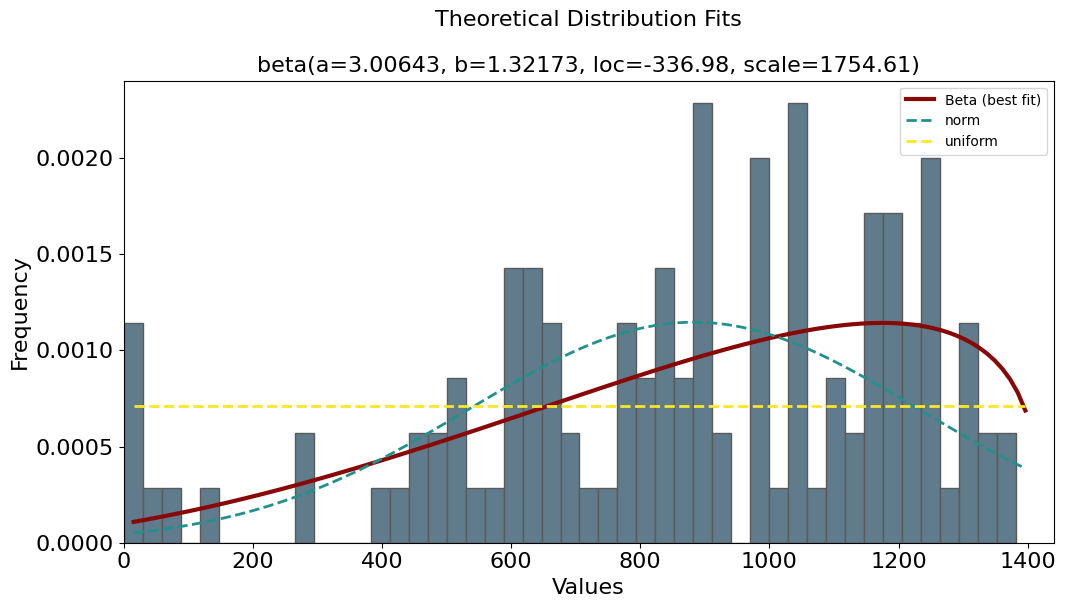

In [45]:
# Count the logins for each interval for weekends
login_intervals_df = pd.DataFrame(columns=["IntervalStart", "LoginCount"])
login_intervals_df.loc[:, "IntervalStart"] = [i for i in range(0, 24*60, 30)]
login_intervals_df.loc[:, "LoginCount"] = 0
login_intervals_df["LoginCount"] = login_intervals_df["LoginCount"].astype(dtype="int64")
for loginTime in login_datetime_df[(login_datetime_df["DayName"] == "Saturday") | (login_datetime_df["DayName"] == "Sunday")]["TimeInMinutes"]:
    intervalIdx = loginTime // 30
    login_intervals_df.loc[intervalIdx, "LoginCount"] += 1
 
# Create a list of appearances of each interval
X = []
for idx in range(len(login_intervals_df)):
    X += [login_intervals_df.loc[idx, "IntervalStart"] + 1] * login_intervals_df.loc[idx, "LoginCount"]
if 1 not in X:
    X.append(1)
if 1411 not in X:
    X.append(1411)
X = pd.Series(X)

# Create the model for normal and uniform distributions
dfit = distfit(distr=["beta", "norm", "uniform"], bins=48)  # Initialize 
dfit.fit_transform(X)   # Fit distributions on empirical data X

# Results
print(f"The data fits best to {dfit.model['name']} distribution with a score of", dfit.model["score"])
print(dfit.summary[["name", "score"]])

# Plot the pdf
fig, ax = plt.subplots(figsize=(12, 6))
plot = dfit.plot(title="Theoretical Distribution Fits\n" , cmap="viridis", cii_properties=None, emp_properties=None, n_top=100, grid=False, xlim=(0, 1440), fig=fig, ax=ax)
fig.savefig("figures/login_times/weekends_pdf_fit.png")
plt.show()

## My Vote vs. Total Score

I will try to see if my vote is correlated with the total score of the posts and comments I voted on.

### Hypothesis
**Null Hypothesis**: My upvote or downvote is not corralated with the total score of the post or comment.  
**Alternative Hypothesis**: I vote up on posts and comments that have a higher score and down on posts and comments that have a lower score.

### Method
I will use a _t-test_ to see if there is a significant difference between the total scores of the posts and comments I upvoted on and the total scores of the posts and comments I downvoted on. (Selecting a significance level of 0.05.)

### Visualization

For better visualization I will use a log scale for the histograms.

In [46]:
scores_df = pd.concat([post_votes_df[["Score", "MyVote"]], comment_votes_df[["Score", "MyVote"]]]).dropna().reset_index(drop=True)
scores_logged = scores_df.copy()
scores_logged["Score"] = scores_df["Score"].map(lambda x: np.log10(x) if x > 0 else 0)

upvoted_posts_chart = alt.Chart(scores_logged[scores_logged["MyVote"] > 0]).mark_bar().encode(
    x=alt.X("Score:Q", title="Scores (log10 spacing)", axis=alt.Axis(labelExpr="pow(10, datum.value)")).bin(minstep=1),
    y=alt.Y("count()"),
    tooltip=["count()"] 
).properties(
    title="Upvoted Posts' Scores",
    width=600,
    height=300,
)

downvoted_posts_chart = alt.Chart(scores_logged[scores_logged["MyVote"] < 0]).mark_bar().encode(
    x=alt.X("Score:Q", title="Scores (log10 spacing)", axis=alt.Axis(labelExpr="pow(10, datum.value)")).bin(minstep=1),
    y=alt.Y("count()"),
    tooltip=["count()"] 
).properties(
    title="Downvoted Posts' Scores",
    width=600,
    height=300,
)

(upvoted_posts_chart & downvoted_posts_chart).configure(
    padding={"left": 15, "right": 15, "top": 15, "bottom": 20},
    title={"fontSize": 18},
).configure_view(
    stroke=None,
).configure_axisX(
    labelFontSize=14,
    titleFontSize=14,
    grid=False,  # Remove the grid
    domainWidth=2,  # Set the width of the axis line
    domainColor="#000"  # Set the color of the axis line
).configure_axisY(
    labelFontSize=14,
    titleFontSize=14,
    grid=False,  # Remove the grid
    domain=False,  # Remove the axis line
)

alt.VConcatChart(...)

In [47]:
# Save the charts
upvoted_posts_chart = upvoted_posts_chart.configure(
    padding={"left": 15, "right": 15, "top": 15, "bottom": 20},
    title={"fontSize": 18},
).configure_view(
    stroke=None,
).configure_axisX(
    labelFontSize=14,
    titleFontSize=14,
    grid=False,  # Remove the grid
    domainWidth=2,  # Set the width of the axis line
    domainColor="#000"  # Set the color of the axis line
).configure_axisY(
    labelFontSize=14,
    titleFontSize=14,
    grid=False,  # Remove the grid
    domain=False,  # Remove the axis line
)
downvoted_posts_chart = downvoted_posts_chart.configure(
    padding={"left": 15, "right": 15, "top": 15, "bottom": 20},
    title={"fontSize": 18},
).configure_view(
    stroke=None,
).configure_axisX(
    labelFontSize=14,
    titleFontSize=14,
    grid=False,  # Remove the grid
    domainWidth=2,  # Set the width of the axis line
    domainColor="#000"  # Set the color of the axis line
).configure_axisY(
    labelFontSize=14,
    titleFontSize=14,
    grid=False,  # Remove the grid
    domain=False,  # Remove the axis line
)

upvoted_posts_chart.save("figures/voted/altair_upvoted_scores.html")
# upvoted_posts_chart.save("figures/voted/altair_upvoted_scores.png")
downvoted_posts_chart.save("figures/voted/altair_downvoted_scores.html")
# downvoted_posts_chart.save("figures/voted/altair_downvoted_scores.png")


### Test

In [48]:
upvoted_scores = scores_df[scores_df["MyVote"] > 0]
downvoted_scores = scores_df[scores_df["MyVote"] < 0]

# Perform t-test
result = stats.ttest_ind(upvoted_scores["Score"], downvoted_scores["Score"], equal_var=False)  # since we have not equal variances

alpha = 0.05  # Set the significance level
if result.pvalue < alpha:
    print("Reject null hypothesis (p-value: {result.pvalue})")
    if result.statistic > 0:
        print("The mean of upvoted scores is greater than the mean of downvoted scores\n")
    else:
        print("The mean of upvoted scores is less than the mean of downvoted scores\n")
else:
    print("Fail to reject null hypothesis (p-value: {result.pvalue})\n")
    print(f"Upvoted: {len(upvoted_scores)}, Downvoted: {len(downvoted_scores)}")

Fail to reject null hypothesis (p-value: {result.pvalue})

Upvoted: 1976, Downvoted: 80


## My Comment vs Parent Post Ownership

Since I am more active in fandom based subreddits in terms of posting posts and comments, I wonder if I interect more on my posts or others'. I will try to see if there is difference between the number of comments and their scores.

### Hypothesis
**Null Hypothesis**: There is no correlation between the ownership of the post and the score of my comment.
**Alternative Hypothesis**: There is a correlation between the ownership of the post and the score of my comment.

### Method
I will use a _t-test_ to see if there is a significant difference between the score of comments I made on posts that I own and the number of comments I made on posts that I do not own. (Selecting a significance level of 0.05.)

In [49]:
ownerships_df = comments_df[["IsPostOwned", "Score"]]
owned_post = ownerships_df[ownerships_df["IsPostOwned"] == 1]
not_owned_post = ownerships_df[ownerships_df["IsPostOwned"] == 0]

# Perform t-test
result = stats.ttest_ind(owned_post["Score"], not_owned_post["Score"], equal_var=False)  # since we have not equal variances

alpha = 0.05  # Set the significance level
if result.pvalue < alpha:
    print(f"Reject null hypothesis (p-value: {result.pvalue:0.5f})")
    if result.statistic > 0:
        print("The mean of owned posts' scores is greater than the mean of not owned posts' scores\n")
    else:
        print("The mean of owned posts' scores is less than the mean of not owned posts' scores\n")
else:
    print(f"Fail to reject null hypothesis (p-value: {result.pvalue})\n")
    print(f"Owned: {len(owned_post)}, Not Owned: {len(not_owned_post)}")

Fail to reject null hypothesis (p-value: 0.10975852559382376)

Owned: 45, Not Owned: 133


## Voted vs Created

### Subs

In [50]:
voted_subs_df = pd.concat([post_votes_df[['SubredditName']], comment_votes_df[['SubredditName']]]).rename(columns={"SubredditName": "Subreddit"})
voted_subs_df["Type"] = "Voted"

created_subs_df = pd.concat([posts_df[['Subreddit']], comments_df[['Subreddit']]])
created_subs_df["Type"] = "Created"

subs_df = pd.concat([voted_subs_df, created_subs_df])

subs_crosstab = pd.crosstab(index=subs_df.Type, columns=subs_df.Subreddit)
# Drop the subs with count less than 5
for col in subs_crosstab.columns:
    if subs_crosstab.loc["Voted", col] < 5 or subs_crosstab.loc["Created", col] < 5:
        subs_crosstab = subs_crosstab.drop(columns=[col])

chi2, p, dof, ex = stats.chi2_contingency(subs_crosstab)

alpha = 0.05  # Set the significance level
result = "independent" if p > alpha else "not independent"
print(f"Type of activity and interacted subreddits are {result}. (p-value: {p})")

Type of activity and interacted subreddits are not independent. (p-value: 1.3869819021709869e-11)


In [51]:
subs_df.reset_index(drop=True, inplace=True)
subs_crosstab = pd.crosstab(index=subs_df.Type, columns=subs_df.Subreddit)
subs_df["count"] = [subs_crosstab[subs_df.loc[i, "Subreddit"]][subs_df.loc[i, "Type"]] for i in range(len(subs_df))]

ch = alt.Chart(subs_df).mark_bar().encode(
    x=alt.X("Subreddit:N", sort="-y"),
    xOffset="Type",
    y=alt.Y("count()", axis=alt.Axis(grid=False)),
    color=alt.Color("Type:N", scale=alt.Scale(domain=["Voted", "Created"],range=["#1f77b4", "#ff7f0e"])),
    tooltip=["count()"]
).configure(
    padding={"left": 15, "right": 15, "top": 15, "bottom": 15},
    title={"fontSize": 18},
).configure_view(
    stroke=None,
).configure_axisX(
    labelFontSize=14,
    titleFontSize=14,
    grid=False,  # Remove the grid
    domainWidth=2,  # Set the width of the axis line
    domainColor="#000"  # Set the color of the axis line
).configure_axisY(
    labelFontSize=14,
    titleFontSize=14,
    grid=False,  # Remove the grid
).transform_filter(
    alt.datum.count > 10
)

# Save the chart
ch.save("figures/voted_vs_created/altair_subs.html")
# ch.save("figures/voted_vs_created/altair_subs.png")
ch

alt.Chart(...)

### Tags

In [52]:
voted_tags_df = pd.concat([post_votes_df[['SubredditName']], comment_votes_df[['SubredditName']]])
voted_tags_df["Tags"] = voted_tags_df["SubredditName"].map(lambda x: subreddits_df[subreddits_df["subreddit"] == x]["Tags"].reset_index(drop=True)[0] if x in subreddits_df["subreddit"].values else None)
voted_tags_df = voted_tags_df.dropna().drop(columns=["SubredditName"])
voted_tags_df = voted_tags_df["Tags"].map(lambda x: x.split(", ")).explode().to_frame()
voted_tags_df["Type"] = "Voted"

created_tags_df = pd.concat([posts_df[['Subreddit']], comments_df[['Subreddit']]])
created_tags_df["Tags"] = created_tags_df["Subreddit"].map(lambda x: subreddits_df[subreddits_df["subreddit"] == x]["Tags"].reset_index(drop=True)[0] if x in subreddits_df["subreddit"].values else None)
created_tags_df = created_tags_df.dropna().drop(columns=["Subreddit"])
created_tags_df = created_tags_df["Tags"].map(lambda x: x.split(", ")).explode().to_frame()
created_tags_df["Type"] = "Created"

tags_df = pd.concat([voted_tags_df, created_tags_df])

tags_crosstab = pd.crosstab(index=tags_df.Type, columns=tags_df.Tags)
# Drop the tags with count less than 5
for col in tags_crosstab.columns:
    if tags_crosstab.loc["Voted", col] + tags_crosstab.loc["Created", col] < 5:
        tags_crosstab = tags_crosstab.drop(columns=[col])

chi2, p, dof, ex = stats.chi2_contingency(tags_crosstab)

alpha = 0.05  # Set the significance level
result = "independent" if p > alpha else "not independent"
print(f"Type of activity and interacted tags are {result}. (p-value: {p})")

Type of activity and interacted tags are not independent. (p-value: 4.660371600940803e-06)


In [53]:
ch = alt.Chart(tags_df).mark_bar().encode(
    x=alt.X("Tags:N", sort="-y"),
    xOffset="Type",
    y=alt.Y("count()", axis=alt.Axis(grid=False)),
    color=alt.Color("Type:N", scale=alt.Scale(domain=["Voted", "Created"],range=["#1f77b4", "#ff7f0e"])),
    tooltip=["count()"]
).configure(
    padding={"left": 15, "right": 15, "top": 15, "bottom": 15},
    title={"fontSize": 18},
).configure_view(
    stroke=None,
).configure_axisX(
    labelFontSize=14,
    titleFontSize=14,
    grid=False,  # Remove the grid
    domainWidth=2,  # Set the width of the axis line
    domainColor="#000"  # Set the color of the axis line
).configure_axisY(
    labelFontSize=14,
    titleFontSize=14,
    grid=False,  # Remove the grid
)

# Save the chart
ch.save("figures/voted_vs_created/altair_tags.html")
# ch.save("figures/voted_vs_created/altair_tags.png")

ch

alt.Chart(...)

### Subbed or not

In [54]:
voted_subbed_df = pd.concat([post_votes_df[["IsSubscribed"]], comment_votes_df[["IsSubscribed"]]])
voted_subbed_df["Type"] = "Voted"

created_subbed_df = pd.concat([posts_df[["IsSubscribed"]], comments_df[["IsSubscribed"]]])
created_subbed_df["Type"] = "Created"

subbed_df = pd.concat([voted_subbed_df, created_subbed_df])

subbed_crosstab = pd.crosstab(index=subbed_df.Type, columns=subbed_df.IsSubscribed).rename(columns={0: "Not Subscribed", 1: "Subscribed"})

chi2, p, dof, ex = stats.chi2_contingency(subbed_crosstab)

alpha = 0.05  # Set the significance level
result = "independent" if p > alpha else "not independent"
print(f"Type of activity and subscription are {result}. (p-value: {p})")

Type of activity and subscription are independent. (p-value: 0.6551931599045688)


In [55]:
ch = alt.Chart(subbed_df).mark_bar().encode(
    x=alt.X("IsSubscribed:N", sort="-y", axis=alt.Axis(labelAngle=-45, labelExpr="datum.value == 0 ? 'Not Subscribed' : 'Subscribed'")),
    xOffset="Type",
    y=alt.Y("count()", axis=alt.Axis(grid=False)),
    color=alt.Color("Type:N", scale=alt.Scale(domain=["Voted", "Created"],range=["#1f77b4", "#ff7f0e"])),
    tooltip=["count()"]
).configure(
    padding={"left": 15, "right": 15, "top": 15, "bottom": 15},
    title={"fontSize": 18},
).configure_view(
    stroke=None,
).configure_axisX(
    labelFontSize=14,
    titleFontSize=14,
    grid=False,  # Remove the grid
    domainWidth=2,  # Set the width of the axis line
    domainColor="#000"  # Set the color of the axis line
).configure_axisY(
    labelFontSize=14,
    titleFontSize=14,
    grid=False,  # Remove the grid
)

# Save the chart
ch.save("figures/voted_vs_created/altair_subbed.html")
# ch.save("figures/voted_vs_created/altair_subbed.png")

ch

alt.Chart(...)

## My Votes vs Tags

In [56]:
upvoted_tags_df = pd.concat([post_votes_df[post_votes_df["MyVote"] > 0][['SubredditName']], comment_votes_df[comment_votes_df["MyVote"] > 0][['SubredditName']]])
upvoted_tags_df["Tags"] = upvoted_tags_df["SubredditName"].map(lambda x: subreddits_df[subreddits_df["subreddit"] == x]["Tags"].reset_index(drop=True)[0] if x in subreddits_df["subreddit"].values else None)
upvoted_tags_df = upvoted_tags_df.dropna().drop(columns=["SubredditName"])
upvoted_tags_df = upvoted_tags_df["Tags"].map(lambda x: x.split(", ")).explode().to_frame()
upvoted_tags_df["Type"] = "Upvoted"

downvoted_tags_df = pd.concat([post_votes_df[post_votes_df["MyVote"] < 0][['SubredditName']], comment_votes_df[comment_votes_df["MyVote"] < 0][['SubredditName']]])
downvoted_tags_df["Tags"] = downvoted_tags_df["SubredditName"].map(lambda x: subreddits_df[subreddits_df["subreddit"] == x]["Tags"].reset_index(drop=True)[0] if x in subreddits_df["subreddit"].values else None)
downvoted_tags_df = downvoted_tags_df.dropna().drop(columns=["SubredditName"])
downvoted_tags_df = downvoted_tags_df["Tags"].map(lambda x: x.split(", ")).explode().to_frame()
downvoted_tags_df["Type"] = "Downvoted"

tag_vote_df = pd.concat([upvoted_tags_df, downvoted_tags_df])

tag_vote_crosstab = pd.crosstab(index=tag_vote_df.Type, columns=tag_vote_df.Tags)
# Drop the tags with count less than 5
for col in tag_vote_crosstab.columns:
    if tag_vote_crosstab.loc["Upvoted", col] < 5 or tag_vote_crosstab.loc["Downvoted", col] < 5:
        tag_vote_crosstab = tag_vote_crosstab.drop(columns=[col])

chi2, p, dof, ex = stats.chi2_contingency(tag_vote_crosstab)

alpha = 0.05  # Set the significance level
result = "independent" if p > alpha else "not independent"
print(f"My vote and interacted tags are {result}. (p-value: {p})")

My vote and interacted tags are not independent. (p-value: 8.29971791527645e-06)


In [57]:
ch = alt.Chart(tag_vote_df).mark_bar().encode(
    x=alt.X("Tags:N", sort="-y"),
    xOffset="Type",
    y=alt.Y("count()", axis=alt.Axis(grid=False)),
    color=alt.Color("Type:N", scale=alt.Scale(domain=["Upvoted", "Downvoted"],range=["#1f77b4", "#ff7f0e"])),
    tooltip=["count()"]
).configure(
    padding={"left": 15, "right": 15, "top": 15, "bottom": 15},
    title={"fontSize": 18},
).configure_view(
    stroke=None,
).configure_axisX(
    labelFontSize=14,
    titleFontSize=14,
    grid=False,  # Remove the grid
    domainWidth=2,  # Set the width of the axis line
    domainColor="#000"  # Set the color of the axis line
).configure_axisY(
    labelFontSize=14,
    titleFontSize=14,
    grid=False,  # Remove the grid
)

# Save the chart
ch.save("figures/voted/altair_tag_vote.html")
# ch.save("figures/voted/altair_tag_vote.png")

ch

alt.Chart(...)